In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input, LSTM, Dense
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load the data
file_path = 'hand_arm_shoulder_landmarks.csv'
data = pd.read_csv(file_path)

# Group by label and series
grouped_data = data.groupby(['Label', 'Series'])

# Prepare sequences and labels
sequences = []
labels = []

for (label, series), group in grouped_data:
    sequences.append(group.drop(columns=['Label', 'Series']).values)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Encode the labels
unique_labels = np.unique(labels)
label_to_index = {label: index for index, label in enumerate(unique_labels)}
encoded_labels = np.array([label_to_index[label] for label in labels])

# Convert labels to categorical using pandas get_dummies
categorical_labels = pd.get_dummies(encoded_labels).values

# Split the data into training and testing sets by series with stratification
X_train, X_test, y_train, y_test, labels_train, labels_test = train_test_split(
    sequences, categorical_labels, labels, test_size=0.2, random_state=42, stratify=labels)

# Display the shape and label for all training and testing sequences
training_shapes_and_labels = [(X_train[i].shape, labels_train[i]) for i in range(len(X_train))]
testing_shapes_and_labels = [(X_test[i].shape, labels_test[i]) for i in range(len(X_test))]


# shape: (series/clips, frames, landmarks)
# Y = series label name

# Display the shape of the training and testing sets
print(f"Training sequences shape: {X_train.shape}")
print(f"Testing sequences shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

# Print the results
print("\nTraining sequences and labels:")
for shape, label in training_shapes_and_labels:
    print(f"Shape: {shape}, Label: {label}")

print("\nTesting sequences and labels:")
for shape, label in testing_shapes_and_labels:
    print(f"Shape: {shape}, Label: {label}")


Training sequences shape: (12, 40, 150)
Testing sequences shape: (4, 40, 150)
Training labels shape: (12, 4)
Testing labels shape: (4, 4)

Training sequences and labels:
Shape: (40, 150), Label: HeadingOut
Shape: (40, 150), Label: ThankYou
Shape: (40, 150), Label: Time
Shape: (40, 150), Label: HeadingOut
Shape: (40, 150), Label: Time
Shape: (40, 150), Label: Hello
Shape: (40, 150), Label: HeadingOut
Shape: (40, 150), Label: ThankYou
Shape: (40, 150), Label: Time
Shape: (40, 150), Label: Hello
Shape: (40, 150), Label: Hello
Shape: (40, 150), Label: ThankYou

Testing sequences and labels:
Shape: (40, 150), Label: Time
Shape: (40, 150), Label: ThankYou
Shape: (40, 150), Label: HeadingOut
Shape: (40, 150), Label: Hello


In [4]:
# Create the LSTM model
model = tf.keras.models.Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(unique_labels), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40, 64)         │        55,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 40, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,636 (818.89 KB)

 Trainable params: 209,636 (818.89 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.3333 - loss: 1.4290 - val_accuracy: 0.5000 - val_loss: 1.3378
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5000 - loss: 1.3303 - val_accuracy: 0.2500 - val_loss: 1.1312
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5000 - loss: 1.1281 - val_accuracy: 0.2500 - val_loss: 1.1712
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3333 - loss: 1.1117 - val_accuracy: 0.2500 - val_loss: 1.1363
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.4167 - loss: 1.0734 - val_accuracy: 0.2500 - val_loss: 1.0844
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5000 - loss: 1.0017 - val_accuracy: 0.5000 - val_loss: 1.0723
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.5833 - loss: 0.9770 - val_accuracy: 0.5000 - val_loss: 1.0849
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6667 - loss: 0.9381 - val_accuracy: 0.7500 - val_loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7500 - loss: 0.6015
Test Loss: 0.6015, Test Accuracy: 0.7500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


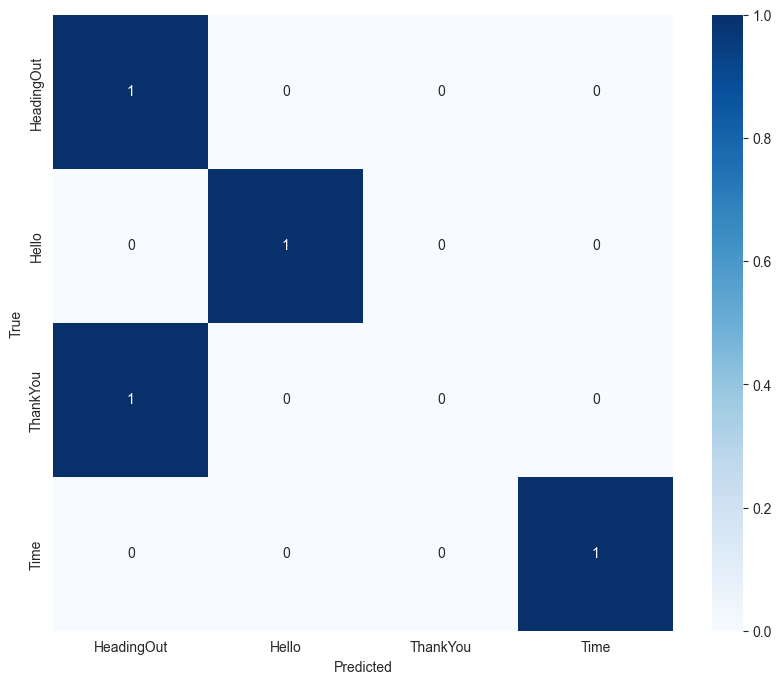

Classification Report
              precision    recall  f1-score   support

  HeadingOut       0.50      1.00      0.67         1
       Hello       1.00      1.00      1.00         1
    ThankYou       0.00      0.00      0.00         1
        Time       1.00      1.00      1.00         1

    accuracy                           0.75         4
   macro avg       0.62      0.75      0.67         4
weighted avg       0.62      0.75      0.67         4



C:\Users\sarpa\PycharmProjects\BlanderAnimator\.venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sarpa\PycharmProjects\BlanderAnimator\.venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sarpa\PycharmProjects\BlanderAnimator\.venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [11]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Function to print confusion matrix and classification report
def print_confusion_matrix(y_true, y_pred, labels, report=True):
    cmx_data = confusion_matrix(y_true, y_pred)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False, cmap='Blues')
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred, target_names=labels))

# Predict on the test set
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print confusion matrix and classification report
print_confusion_matrix(y_true, y_pred, unique_labels)

In [7]:
# Save the model
model.save("gesture_recognition_lstm_model.hdf5", include_optimizer=False)

In [ ]:
# Convert the model to TensorFlow Lite format with quantization
tflite_save_path = 'hand_gesture_model.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Save the TensorFlow Lite model
with open(tflite_save_path, 'wb') as f:
    f.write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\sarpa\AppData\Local\Temp\tmpwfksi50l\assets


INFO:tensorflow:Assets written to: C:\Users\sarpa\AppData\Local\Temp\tmpwfksi50l\assets


In [ ]:
# Inference test with TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Set the input tensors
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

# Perform inference
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

# Print results
print("TFLite Model Results:", np.squeeze(tflite_results))
print("Predicted Class:", np.argmax(np.squeeze(tflite_results)))